In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [23]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [24]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [25]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, loss_l1=F.l1_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_l1 = loss_l1
        self.loss_fn = loss_fn
        self._loss_l1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_l1 = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def lossl1(self, l1_weight=1.):
        self._loss_l1 = torch.abs(self.data_l1).sum() * l1_weight
        return self._loss_l1        
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [26]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
l1_weight = 1.
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [27]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            _loss_mse = model.loss(output, data)
            _loss_l1 = model.lossl1(l1_weight)
            loss = _loss_mse + _loss_l1
#             print (_loss_mse, _loss_l1)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._loss_l1))
        print(line + losses)

In [28]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
l1_lambda = lambda p: 'l1_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + l1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    test_loss = {k: 0. for k in models}
    l1_test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                l1_test_loss[k] += m.lossl1(l1_weight).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        l1_test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k], l1_test_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], l1_test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [29]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.988163 32: 0.995263 64: 0.969999
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.911269 32: 0.910115 64: 0.903419
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.881589 32: 0.879149 64: 0.872112
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.851347 32: 0.850378 64: 0.845795
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.829230 32: 0.826792 64: 0.820273
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.802796 32: 0.800335 64: 0.795790
Test set:
16: loss: 0.8051	l1_loss: 0.0010
32: loss: 0.8026	l1_loss: 0.0020
64: loss: 0.7968	l1_loss: 0.0041

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.803392 32: 0.800332 64: 0.795657
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.781801 32: 0.776827 64: 0.771905
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.763647 32: 0.760531 64: 0.755524
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.737265 32: 0.733864 64: 0.728104
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.715397 32: 0.713595 64: 0.706459
Train Ep

Test set:
16: loss: 0.2888	l1_loss: 0.0001
32: loss: 0.2884	l1_loss: 0.0003
64: loss: 0.2879	l1_loss: 0.0006

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.279712 32: 0.279298 64: 0.278836
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.275370 32: 0.274871 64: 0.274286
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.279546 32: 0.279141 64: 0.278880
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.286444 32: 0.286015 64: 0.285780
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.271389 32: 0.271120 64: 0.270583
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.277290 32: 0.276892 64: 0.276350
Test set:
16: loss: 0.2843	l1_loss: 0.0001
32: loss: 0.2839	l1_loss: 0.0003
64: loss: 0.2835	l1_loss: 0.0005

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.287541 32: 0.287071 64: 0.286764
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.290407 32: 0.290002 64: 0.289907
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.271994 32: 0.271541 64: 0.271401
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.30

In [31]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


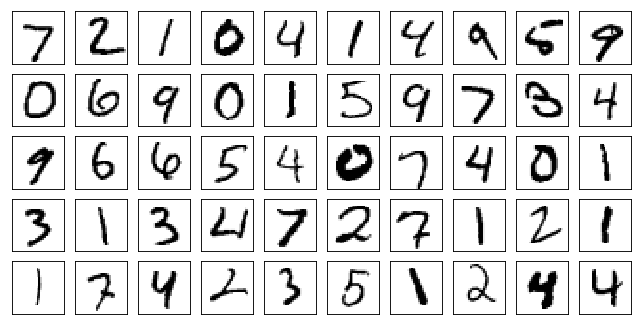

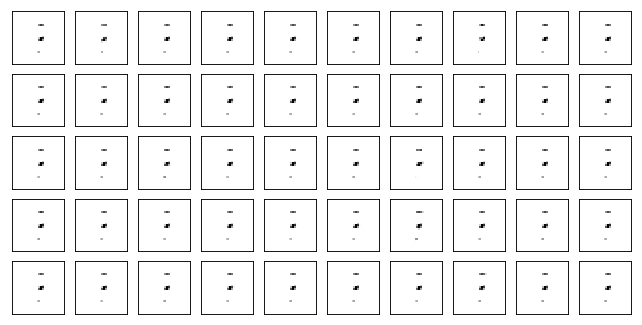

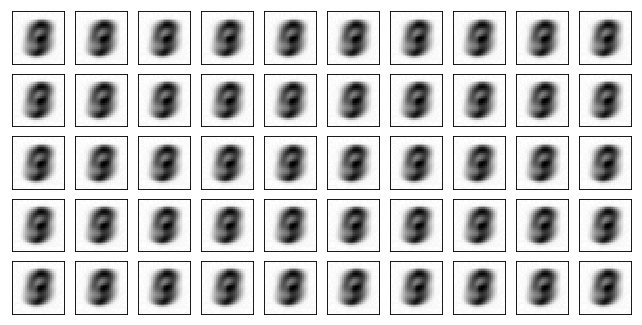

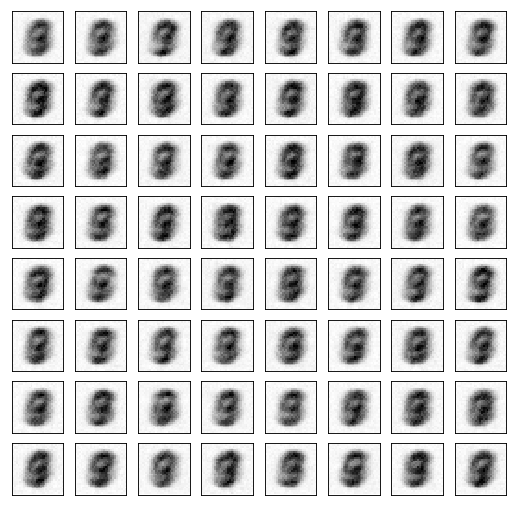

In [32]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))